In [68]:
import pandas as pd
import numpy as np
import datetime
import tqdm #進度條
import talib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data = pd.read_csv('data/1019_SP.csv')
data1 = pd.read_csv("data/1019_CL.csv").dropna()
data2 = pd.read_csv("data/1019_OVX.csv").dropna()
data3 = pd.read_csv("data/1019_GC.csv").dropna()
data4 = pd.read_csv("data/1019_GVZ.csv").dropna()
Date = data.get("Date")
Date = pd.to_datetime(Date)
Open = data.get("Open")
High = data.get("High")
Low = data.get("Low")
Close = data.get("Close")
Close_cl = data1.get("Close")
Close_ovx = data2.get("Close")
Close_gc = data3.get("Close")
Close_gvz = data4.get("Close")

dict = {"Date": Date,
        "open": Open,
        "high": High,
        "low": Low, 
        "close": Close,
        "close_cl": Close_cl, 
        "close_ovx": Close_ovx,
        "close_gc": Close_gc, 
        "close_gvz": Close_gvz,
        "return":0,
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:2493個交易時間點
去除空白值後剩下:2493個交易時間點


,open,high,low,close,close_cl,close_ovx,close_gc,close_gvz,return
Date,,,,,,,,,
2019-12-13,3166.649902,3182.679932,3156.510010,3168.800049,60.070000,26.760000,1475.599976,10.39,0
2019-12-16,3183.629883,3197.709961,3183.629883,3191.449951,60.209999,26.510000,1475.000000,10.39,0
2019-12-17,3195.399902,3198.219971,3191.030029,3192.520020,60.939999,26.330000,1474.599976,10.03,0
2019-12-18,3195.209961,3198.479980,3191.139893,3191.139893,60.930000,26.770000,1472.599976,10.04,0
2019-12-19,3192.320068,3205.479980,3192.320068,3205.370117,61.220001,24.799999,1478.199951,10.39,0
2019-12-20,3223.330078,3225.649902,3216.030029,3221.219971,60.439999,25.540001,1474.699951,9.69,0
2019-12-23,3226.050049,3227.780029,3222.300049,3224.010010,60.520000,25.110001,1482.500000,10.56,0
2019-12-26,3227.199951,3240.080078,3227.199951,3239.909912,61.680000,24.080000,1509.300049,13.33,0
2019-12-27,3247.229980,3247.929932,3234.370117,3240.020020,61.720001,25.160000,1513.800049,12.32,0


In [ ]:
def create_labels(df,col_name,window_size=11):
  row_counter = 0
  total_rows = len(df)
  labels = np.zeros(total_rows)
  labels[:]=np.nan
  #pbar = tqdm.tqdm(total=total_rows)
  while row_counter <total_rows:
    if row_counter>=window_size-1:
      window_begin=row_counter-(window_size-1)
      window_end=row_counter
      window_middle=(window_begin+window_end)/2
      min_=np.inf
      min_index=-1
      max_=-np.inf
      max_index=-1
      for i in range(window_begin,window_end+1):
        price = df.iloc[i][col_name]
        if price<min_:
          min_=price
          min_index=i
        elif price>max_:
          max_=price
          max_index=i
      if max_index == window_middle:
        labels[row_counter] = 2
      elif min_index == window_middle:
        labels[row_counter] = 0
      else:
        labels[row_counter] = 1
    row_counter = row_counter+1
    #pbar.update(1)
  #pbar.close()
  return labels
df['return'] = create_labels(df,'close')

In [ ]:
ema = talib.EMA(df['close'])
sma = talib.SMA(df['close'])
roc = talib.ROC(df['close'])
macd, macdsignal, macdhist = talib.MACD(df['close'])
k, d = talib.STOCH (df['high'], df['low'], df['close'])
upper, middle, lower = talib.BBANDS(df['close'])
B = (df['close'] - lower)/(upper - lower)

dataset = pd.DataFrame({
    'Close':df['close'],    
    'EMA':ema,
    'SMA':sma,
    'ROC':roc,
    'MACD':macd,
    '%K':k,
    '%D':d,
    'Upper Band':upper,
    'Lower Band':lower,
    '%B':B,
    'Close_CL':df['close_cl'],
    'Close_OVX':df['close_ovx'],
    'Close_GC':df['close_gc'],
    'Close_GVZ':df['close_gvz'],
    'return': df['return'],
})

feature_names = list(dataset.columns[:-1])

In [71]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (2493, 15)
after dropping NaN (2460, 15)


In [72]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,EMA,SMA,ROC,MACD,%K,%D,Upper Band,Lower Band,%B,Close_CL,Close_OVX,Close_GC,Close_GVZ,return
count,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,0.428129,0.424185,0.425646,0.656687,0.641694,0.606793,0.615276,0.431052,0.426996,0.557574,0.527046,0.289860,0.356860,0.258850,1.006504
std,0.263129,0.278491,0.278821,0.100666,0.134407,0.264417,0.251097,0.265637,0.261981,0.287313,0.251470,0.157534,0.212476,0.154939,0.355000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.170140,0.147477,0.151014,0.608373,0.573992,0.395688,0.418844,0.168011,0.171626,0.297806,0.296597,0.186405,0.209661,0.141213,1.000000
50%,0.437414,0.435432,0.433881,0.664884,0.665200,0.647005,0.653687,0.439382,0.437114,0.629983,0.503990,0.267954,0.291145,0.243000,1.000000
75%,0.638417,0.647352,0.652223,0.719253,0.726499,0.844265,0.834867,0.638581,0.641608,0.802273,0.769180,0.377346,0.472819,0.343096,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000


1.0    2150
2.0     163
0.0     147
Name: return, dtype: int64


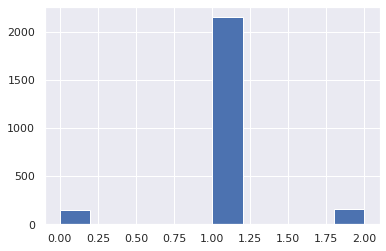

In [73]:
result = pd.value_counts(dataset_scaled['return'])
print(result)
dataset_scaled['return'].hist()

In [74]:
from keras.utils import np_utils
#每張圖包含幾天的資料
time_period = 20
#預設幾日後的漲跌
day = 1

cnn_x = []
cnn_y = []
indexs = []
dataset_scaled_x= dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-time_period-1-day)):
    cnn_x.append(dataset_scaled_x.iloc[i:i+time_period].values)
    r = dataset_scaled['return'].iloc[i+time_period-1+day]
    rr = np_utils.to_categorical(r, num_classes=3)
    cnn_y.append(rr)
    indexs.append(dataset_scaled.index[i+time_period-1])
    
cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
cnn_x_t = cnn_x[indexes < datetime.datetime(2019,1,1)]
cnn_y_t = cnn_y[indexes < datetime.datetime(2019,1,1)]
cnn_x_validation = cnn_x[indexes > datetime.datetime(2019,1,1)]
cnn_y_validation = cnn_y[indexes > datetime.datetime(2019,1,1)]

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
def get_sample_weights(y):
  y = y.astype(int)
  class_weight = compute_class_weight('balanced',np.unique(y),y)
  print("real class weight are{}".format(class_weight),np.unique(y))
  print("value_counts",np.unique(y,return_counts=True))
  sample_weights = y.copy().astype(float)
  for i in np.unique(y):
    sample_weights[sample_weights==i]=class_weight[i]
  return class_weight,sample_weights

In [77]:
#將onehot編碼轉回數組
lable = np.argmax(cnn_y_t, axis=1)
lable = np.array(lable)
class_weight,sample_weights = get_sample_weights(lable)

real class weight are[5.45522388 0.38272251 4.90604027] [0 1 2]
value_counts (array([0, 1, 2]), array([ 134, 1910,  149]))


In [78]:
class_weight={0:class_weight[0],
              1:class_weight[1],
              2:class_weight[2],}
print(class_weight)

{0: 5.455223880597015, 1: 0.38272251308900523, 2: 4.906040268456376}


In [ ]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential

def get_model(dropout1_rate=0.5, dropout2_rate=0.5):
  
    model = Sequential()
    model.add(layers.Conv1D(100, 10, activation='relu', input_shape=cnn_x_t[0].shape))
    model.add(layers.MaxPooling1D(2))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.Dropout(dropout1_rate, name="dropout_1"))
    model.add(layers.LSTM(128))
    model.add(layers.Dropout(dropout2_rate, name="dropout_2"))
    model.add(layers.Dense(units=32, activation='relu'))
    model.add(layers.Dense(units=3, activation='softmax'))

    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='loss', patience=10, verbose=1)

def fit_with(dropout1_rate, dropout2_rate, lr, batchsize):

    # batchsize只能是整數，強迫把浮點轉int
    batchsize = int(batchsize)

    # 使用指定的超參數創建模型。
    model = get_model(dropout1_rate, dropout2_rate)
    
    # 設定優化器、學習率並建模
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    
    # 使用訓練數據集訓練模型。
    model.fit(cnn_x_t, cnn_y_t,
              batch_size = batchsize,
              epochs=250,
              verbose=0,
              validation_split = 0.2,
              callbacks=[earlystop],
              class_weight=class_weight,
              )
    # steps=10 = 評估階段結束之前的步驟總數（樣本批次）
    # score = model.evaluate(cnn_x_test,cnn_y_test, steps=10, verbose=0)
    # 使用測試數據集評估模型。
    score = model.evaluate(cnn_x_t, cnn_y_t, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])

    return score[1]

In [23]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
        fit_with,
        {'dropout1_rate': (0, 0.5),
        'dropout2_rate': (0, 0.5),
        'lr': (1e-5, 1e-2),
        'batchsize': (16,128)}
    )
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | batchsize | dropou... | dropou... |    lr     |
-------------------------------------------------------------------------
Epoch 00014: early stopping
|  1        |  0.0611   |  63.36    |  0.2584   |  0.01182  |  0.008248 |
Epoch 00018: early stopping
|  2        |  0.0611   |  80.32    |  0.2999   |  0.3229   |  0.008521 |
Epoch 00015: early stopping
|  3        |  0.0611   |  122.6    |  0.1845   |  0.1446   |  0.00904  |
Epoch 00020: early stopping
|  4        |  0.0611   |  20.72    |  0.2889   |  0.2213   |  0.00663  |
Epoch 00014: early stopping
|  5        |  0.0611   |  114.3    |  0.07909  |  0.1252   |  0.006545 |
Epoch 00023: early stopping
|  6        |  0.0611   |  46.47    |  0.02212  |  0.3244   |  0.004398 |
Epoch 00037: early stopping
|  7        |  0.0611   |  30.12    |  0.3819   |  0.2614   |  0.007415 |
Epoch 00055: early stopping
|  8        |  0.6443   |  115.0    |  0.1115   |  0.4771   |  0.00465  |
Epoch 00025: early stopping
|  9    

In [24]:
print(optimizer.max)
print(optimizer.max['params']['dropout1_rate'])
print(optimizer.max['params']['dropout2_rate'])
print(optimizer.max['params']['lr'])
print(optimizer.max['params']['batchsize'])
##Bayesian Optimization 找到的最佳超參數值
dropout_rate1 = optimizer.max['params']['dropout1_rate']
dropout_rate2 = optimizer.max['params']['dropout2_rate']
learning_rate = optimizer.max['params']['lr']
batchsize = int(optimizer.max['params']['batchsize'])

{'target': 0.8709530234336853, 'params': {'batchsize': 88.46720839005762, 'dropout1_rate': 0.013593513591900419, 'dropout2_rate': 0.2034667691330277, 'lr': 0.008593036447150655}}
0.013593513591900419
0.2034667691330277
0.008593036447150655
88.46720839005762


In [ ]:
dropout_rate1 = 0.01359
dropout_rate2 = 0.2035
learning_rate =  0.008593
batchsize = int(88.47)

In [83]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

model = Sequential()
model.add(layers.Conv1D(100, 10, activation='relu', input_shape=cnn_x_t[0].shape))
model.add(layers.MaxPooling1D(2))
model.add(layers.LSTM(128, return_sequences=True, input_shape=cnn_x[0].shape))
model.add(layers.Dropout(dropout_rate1, name="dropout_1"))
model.add(layers.LSTM(128))
model.add(layers.Dropout(dropout_rate2, name="dropout_2"))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=3, activation='softmax'))

adam = tensorflow.keras.optimizers.Adam(learning_rate)

model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_34 (Conv1D)           (None, 11, 100)           14100     
_________________________________________________________________
max_pooling1d_34 (MaxPooling (None, 5, 100)            0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 5, 128)            117248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 5, 128)            0         
_________________________________________________________________
lstm_69 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_68 (Dense)             (None, 32)              

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='loss', patience=10, verbose=1)

history = model.fit(cnn_x_t, cnn_y_t,
                    batch_size=batchsize,
                    epochs=250,
                    verbose=1,
                    validation_split = 0.2,
                    #callbacks=[earlystop],
                    class_weight=class_weight,
                    )

Epoch 1/250
20/20 [==============================] - 1s 38ms/step - loss: 1.1470 - accuracy: 0.3216 - val_loss: 1.0207 - val_accuracy: 0.8793
Epoch 2/250
20/20 [==============================] - 0s 7ms/step - loss: 1.1224 - accuracy: 0.2691 - val_loss: 1.0963 - val_accuracy: 0.0661
Epoch 3/250
20/20 [==============================] - 0s 7ms/step - loss: 1.1134 - accuracy: 0.7811 - val_loss: 1.0968 - val_accuracy: 0.8793
Epoch 4/250
20/20 [==============================] - 0s 7ms/step - loss: 1.1107 - accuracy: 0.0992 - val_loss: 1.1130 - val_accuracy: 0.0547
Epoch 5/250
20/20 [==============================] - 0s 6ms/step - loss: 1.1106 - accuracy: 0.0627 - val_loss: 1.1066 - val_accuracy: 0.0547
Epoch 6/250
20/20 [==============================] - 0s 7ms/step - loss: 1.1102 - accuracy: 0.0627 - val_loss: 1.1153 - val_accuracy: 0.0547
Epoch 7/250
20/20 [==============================] - 0s 7ms/step - loss: 1.1109 - accuracy: 0.0627 - val_loss: 1.1140 - val_accuracy: 0.0547
Epoch 8/250


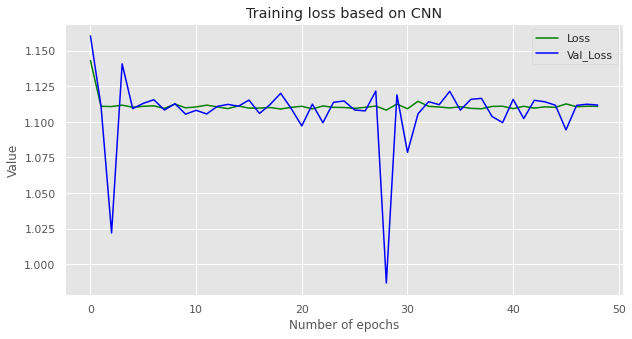

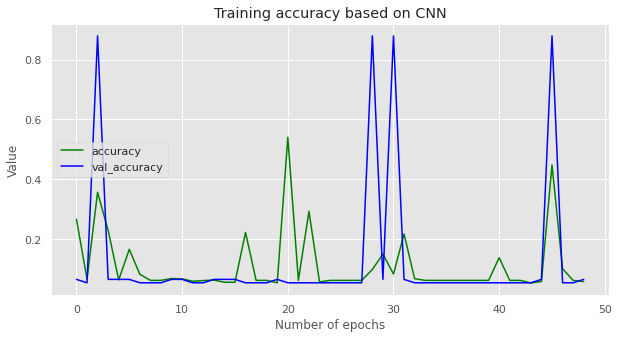

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], color = 'green', label='Loss')
plt.plot(history.history['val_loss'], color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='val_accuracy')
plt.legend()
plt.title('Training accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


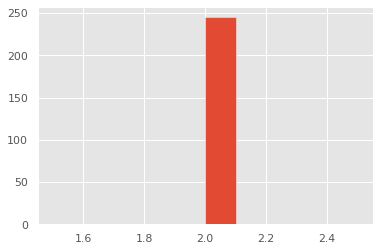

In [61]:
#將onehot編碼轉回數組cnn_x_validation
cnn_y_validation = np.argmax(cnn_y_validation, axis=1)
xcnn_y_validation = pd.Series(cnn_y_validation)
#預測
pre = model.predict_classes(cnn_x_validation)
pre = pd.Series(pre)
pre.hist()


驗證資料總共：245.00 筆
其中 Buy 的筆數為: 13.00, 全部猜 Buy 猜對的機率是: 0.05
其中 Hold 的筆數為: 220.00, 全部猜 Hold 猜對的機率是: 0.90
其中 Sell 的筆數為: 12.00, 全部猜 Sell 猜對的機率是: 0.05

該測試集資料的 Accuracy 為: 0.05 
Precision(Buy): nan, Recall(Buy): 0.00, F1 score(Buy): nan
Precision(Hold): nan, Recall(Hold): 0.00, F1 score(Hold): nan
Precision(Sell): 0.05, Recall(Sell): 1.00, F1 score(Sell): 0.10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in long_scalars


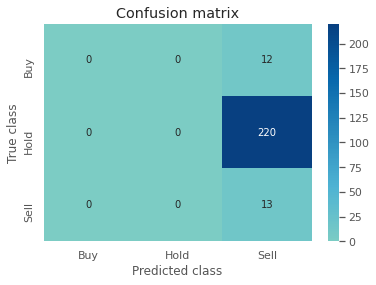

In [62]:
from sklearn.metrics import confusion_matrix

LABELS = ["Buy","Hold","Sell"]
conf_matrix = confusion_matrix(xcnn_y_validation, pre)

#原始資料
t_size = len(cnn_y_validation)
b_size = (cnn_y_validation>=2).sum()
s_size = (cnn_y_validation<=0).sum()
h_size = t_size-(b_size+s_size)
b_guess = b_size/t_size
s_guess = s_size/t_size
h_guess = h_size/t_size
#矩陣數字
c00 = conf_matrix[0][0]
c01 = conf_matrix[0][1]
c02 = conf_matrix[0][2]
c10 = conf_matrix[1][0]
c11 = conf_matrix[1][1]
c12 = conf_matrix[1][2]
c20 = conf_matrix[2][0]
c21 = conf_matrix[2][1]
c22 = conf_matrix[2][2]
#評估指標
accuracy = (c00+c11+c22)/t_size
precision_b = c00/(c00+c10+c20)
precision_h = c11/(c01+c11+c21)
precision_s = c22/(c02+c12+c22)
recall_b = c00/(c00+c01+c02)
recall_h = c11/(c10+c11+c12)
recall_s = c22/(c20+c21+c22)
F1_b = 2*((precision_b*recall_b)/(precision_b+recall_b))
F1_h = 2*((precision_h*recall_h)/(precision_h+recall_h))
F1_s = 2*((precision_s*recall_s)/(precision_s+recall_s))
#印出
#print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
#print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n驗證資料總共：%.2f 筆\n其中 Buy 的筆數為: %.2f, 全部猜 Buy 猜對的機率是: %.2f" % (t_size, b_size, b_guess))
print("其中 Hold 的筆數為: %.2f, 全部猜 Hold 猜對的機率是: %.2f" % (h_size, h_guess))
print("其中 Sell 的筆數為: %.2f, 全部猜 Sell 猜對的機率是: %.2f" % (s_size, s_guess))
print("\n該測試集資料的 Accuracy 為: %.2f \nPrecision(Buy): %.2f, Recall(Buy): %.2f, F1 score(Buy): %.2f" % (accuracy, precision_b, recall_b, F1_b))
print("Precision(Hold): %.2f, Recall(Hold): %.2f, F1 score(Hold): %.2f" % (precision_h, recall_h, F1_h))
print("Precision(Sell): %.2f, Recall(Sell): %.2f, F1 score(Sell): %.2f" % (precision_s, recall_s, F1_s))
#畫圖
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

In [63]:
result = pd.value_counts(xcnn_y_validation)
print(result)

1    220
2     13
0     12
dtype: int64


In [ ]:
f = df['close'][2248:]
a = []
b = []
for i in range(len(f)):
  a.append(f[i])
  b.append(pre[i])
  #b.append(xcnn_y_validation[i])
a = np.array(a)
b = np.array(b)

S_dataset = pd.DataFrame({
    'price':a,    
    'signal':b,
}) 

In [ ]:
#起始資金10000美金，每次交易手續費9美金(以eToro為例)，stock是現在持有的股票數，previous上一部的狀態一樣則不動作。
total_money = 10000
Handling_fee = 9
stock = 0
previous = 1
for i in range(len(S_dataset)):
  total_money = total_money
  stock = stock
  previous = previous
  now = S_dataset['signal'][i]
  if now == previous:
    previous = now
  else:
    if now == 2:
      if stock!=0:
        total_money = total_money+(S_dataset['price'][i]*stock)
        total_money = total_money-Handling_fee
        stock=0
    elif now == 0:
      if total_money>S_dataset['price'][i]:
        stock = int(total_money/S_dataset['price'][i])
        total_money = total_money-(stock*S_dataset['price'][i])
    previous = now

In [ ]:
total = total_money+(S_dataset['price'][len(S_dataset)-1]*stock)-Handling_fee

In [67]:
#Return on investment (%)
print(((total-10000)/10000)*100)

-0.09
